# Assignment 3: Unsupervised Learning

In this assignment you will:
* Implement K-means clustering and use it for color-quantization of images
* Train a MoG model by implementing the EM algorithm. Compare to K-means on the same test data. 
* Use PCA for image compression

# Part 1: K-Means Clustering

## Setup

First import the required packages and do some setup:

In [1]:
from __future__ import print_function

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from assignment3 import kmeans, kmeans_colors, em_mog, em_segmentation, getEigenImages

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'

%load_ext autoreload
%autoreload 2



Let's generate some test-data for you to test your implementation of the k-means and EM algorithm. Note that we generate gaussian blobs with non-isotropic covariance matrices. 

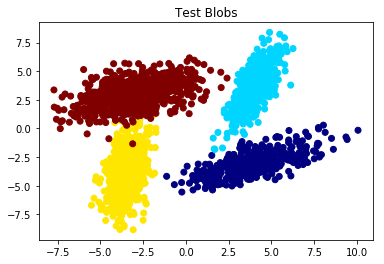

In [3]:
# Generate samples of 4 different Gaussians
rv1 = multivariate_normal.rvs([4.0, -3.], [[4.0, 1.5], [1.5, 1.1]], size=400)
rv2 = multivariate_normal.rvs([4.0, 3.5], [[1.0, 2.3], [0.8, 2.75]], size=500)
rv3 = multivariate_normal.rvs([-3.5, -4.0], [[0.5, 1.0], [0.3, 3.]], size=600)
rv4 = multivariate_normal.rvs([-3., 3.], [[2.5, 0.1], [2.3, 1.5]], size=700)

# Concatenate the samples and create corresponding labels
X = np.concatenate([rv1, rv2, rv3, rv4], 0)
y = np.array([0]*400+[1]*500+[2]*600+[3]*700)

# Plot the test data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Test Blobs")
plt.show()



## Exercise 1: K-Means Clustering [15 Points]

You will now implement the standard k-means clustering algorithm and test it on the generated test data. 

**TODO**: Implement the k-means clustering algorithm in ***kmeans.py*** according to specs and test your implementation with the provided test data.


Number of iterations: 100, Execution time: 2.36030316353s


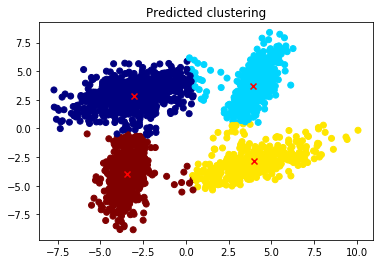

In [4]:
# Test your implementation
centers, assign = kmeans(X, 4)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=assign)
plt.scatter(centers[:, 0], centers[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()


## Exercise 2: Questions about K-means [10 Points]

* Does k-means always result in the same clustering? Why?

***Your Answer:*** no it does not since the starting points of the algorithm are generated at random and this obviously influences the distance between the clustercenter and each data sample.

* Would you expect K-means to work better in the case of data generated from isotropic Gaussian distributions? Why?

***Your Answer:*** yes i would since then the difference between the gaussians would be bigger as the samples are more centered which will lead to heavier convergence towards the mean of the gausians

## Exercise 3: Using k-means for image compression [10 Points]

You will now use K-means to cluster pixel values of an image and use the cluster assignments as a way to quantize/compress the color-space of the image. Replace each pixel with the mean of the assigned cluster.
You should use the implementation provided through sklearn in this exercise ([sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

Feel free to test the algorithm on your own images and with different numbers of clusters.

**TODO**: Implement the color-quantization through k-means in ***kmeans_colors.py*** according to specs. 


/home/pascal/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


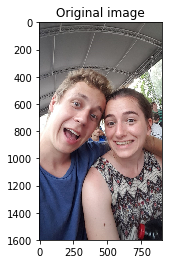

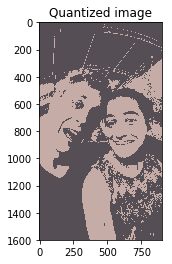

/home/pascal/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


In [5]:
# Load and show test image
img = misc.imread('image.jpeg')
plt.imshow(img)
plt.title("Original image")
plt.show()

# Compute quantized image
k = 2
img_cl = kmeans_colors(img, k)

# Show the quantized image
plt.imshow(img_cl)
plt.title("Quantized image")
plt.show()
misc.imsave('quantized.png', img_cl)

# Part 2: Expectation Maximization

In the second part of the assignment you will implement the EM algorithm for Mixture of Gaussian (MoG) models. You will then use this model on the problem of image-segmentation.


## Exercise 4: EM for MoG [25 Points]

**TODO:** Implement the **EM** algorithm for Mixture of Gaussian models in **em_mog.py** according to specs. Test your implementation on the provided test data.  

Iter: 1/20, LL: -10767.8885653
Iter: 2/20, LL: -10616.8330562
Iter: 3/20, LL: -10625.9728955
EM has converged...
Number of iterations: 3, Execution time: 2.56529307365s


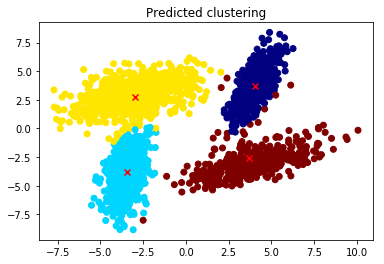

In [15]:
# Test your implementation
phi, mu, sigma, w = em_mog(X, 4)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(w, 1))
plt.scatter(mu[:, 0], mu[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()


## Exercise 5: Questions about MoG [10 Points]

* Does the MoG model perform better than K-means on the provided test data? Why?

***Your Answer:*** The k-means algorithm performs better on the provided test data. This is likely because of the huge number of features that are considered with the MoG model compared to K-means.


* What are advantages and disadvantages of MoG vs. K-means?

***Your Answer:*** Advantages: MoG are a lot more flexible in terms of cluster covariance, since clusters in MoG have unconstrained covariance structure and therefore take covariance into account when calculating distances. K-means however calculates the euclidean distance to perform clustering of data points. Mog therefor performs better on non-spherical data.

With K-means it can be difficult to predict the perfect value of k (usually a random guess as we don't assume too much about the data or it's distributions), this  means that the initial clusters will usually result in different final partitions. It also doesn't work well with clusters of different sizes and data point densities.

Disadvantages: K-means tends to converge faster than MoG, due to fewer assumptions and parameters which it considers.

## Exercise 6: EigenFaces with PCA [5 Points]
In this exercise you will implement an image compression method using PCA. 
Below are the steps that you need to do:
* Stack all the images of faces in the design matrix 
* Perform SVD (Singular Value Decomposition) of the design matrix
* Get the _right_ eigenvectors corresponding to the N largest eigenvalues
* Project a test image onto the basis of eigenvectors from the previous step

In order to reconstruct the compressed image you need to compute the linear combination of the projection coefficients and corresponding _right_ eigenvectors. For more details please visit: https://en.wikipedia.org/wiki/Principal_component_analysis

Loading the dataset of faces

In [31]:
data = loadmat('faces.mat')
labels = np.squeeze(data['Labels'])
data = data['Data']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
num_train = X_train.shape[0]
num_test = X_test.shape[0]

# Zero centering data
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=False)
scaler.fit(data[labels==1])

# Selecting only faces
X_faces_train = scaler.transform(X_train[y_train==1])
X_faces_test = scaler.transform(X_test[y_test==1])



Displaying some of the samples

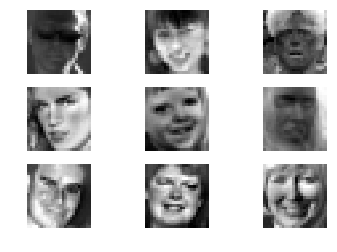

In [32]:
for i in range(1,10):
    plt.subplot(3, 3, i)
    plt.imshow(np.reshape(X_faces_train[i-1,:], [24, 24], order='F'), cmap='gray')
    plt.axis('off')

plt.show()
plt.close()


Apply PCA to the training images

In [33]:

U=None 
S=None 
Vh=None

#######################################################################
# TODO:                                                               #
#      Perform the singular value decomposition (SVD) of the face     #
#      data matrix and    #
#      extract the eigenvectors              xDx                         #
#      Input: X_faces_train
#      Output: U, S, and Vh matrices of the SVD
#######################################################################

U, S, Vh = np.linalg.svd(X_faces_train)

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

Display some of the EigenFaces

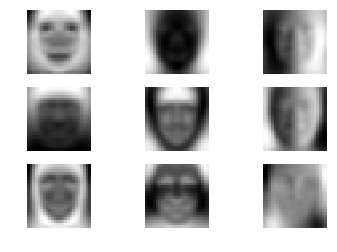

In [34]:
eigenface = np.reshape(Vh, [-1, 24, 24], order='F')

N=9

for i in range(1,N+1):
    plt.subplot(int(np.sqrt(N)), int(np.sqrt(N)), i)
    plt.imshow(eigenface[i-1], cmap='gray')
    plt.axis('off')

plt.show()
plt.close()

## Exercise 7: Compression using PCA [10 Points]

Compress the test set images using eigenvectors computed in the previous exercise

**TODO:** Implement the **Compression with PCA** in **getEigenImages.py** according to specs.

In [40]:
# Selecting some number of EigenFaces
num_components = 200
basis = Vh[:num_components,:].T

eigen_coefficients, reconstruction = getEigenImages(X_faces_test, basis)

Test your implementation on the provided test data. Display the reconstructed and original images side-by-side

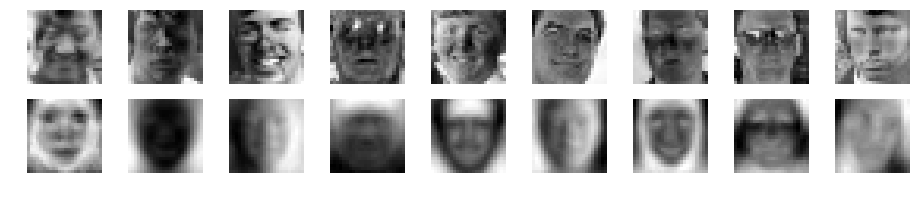

In [41]:
reconstructed_images = np.reshape(reconstruction,[-1, 24,24], order='F')
test_images = np.reshape(X_faces_test,[-1, 24,24], order='F')

plt.rcParams['figure.figsize'] = (16.0, 3.0)

num_faces = 9

for i in range(1,num_faces+1):
    plt.subplot(2, num_faces, i)
    plt.imshow(test_images[i-1,:,:], cmap='gray')
    plt.axis('off')
    plt.subplot(2, num_faces, num_faces + i)
    plt.imshow(reconstructed_images[i-1,:,:], cmap='gray')
    plt.axis('off')

plt.show()
plt.close()

## Exercise 8: Evaluating the Quality of the Compression [5 Points]

Compress the images from the test set using different numbers of eigenvectors. Measure the quality of the reconstructions using MSE. Plot the dependency of MSE on the number of eigenvectors used for the reconstruction. Recall that the MSE between two images is defined as

$$MSE(X,Y)= \frac { 1 } { m n } \sum _ { i = 0 } ^ { m - 1 } \sum _ { j = 0 } ^ { n - 1 } [ X ( i , j ) - Y ( i , j ) ] ^ { 2 }$$

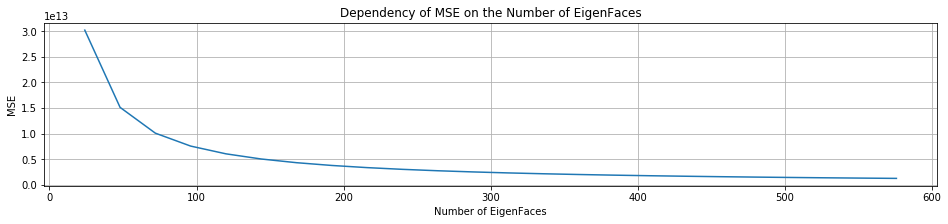

In [63]:
num_eigen_vectors_list = range(24,577,24)
mse_list = []

for num_eigen_vectors in num_eigen_vectors_list:
    basis = Vh[:num_eigen_vectors,:].T
    
    eigen_coefficients, reconstruction = getEigenImages(X_faces_test, basis)
    
    #######################################################################
    # TODO:                                                               #
    #      Compute MSE between reconstruction and original image          #                                  
    #######################################################################
    
    MSE = ((reconstruction - X_faces_test[:num_eigen_vectors, :]) ** 2).mean()
    mse_list.append(MSE)
    
    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    
fig, ax = plt.subplots()
ax.plot(num_eigen_vectors_list, mse_list)

ax.set(xlabel='Number of EigenFaces', ylabel='MSE',
       title='Dependency of MSE on the Number of EigenFaces')
ax.grid()
plt.show()

## Exercise 9: EigenFace with PCA [10 Points]

* In the lecture notes you were computing the eigenvectors of the data covariance matrix, while in assignment you computed them by directly performing SVD on the design matrix. What is the difference between the two approaches? Which approach is better? Justify your answer.

***Your Answer:*** When the matrix has at least one large dimension, calculating the SVD is much more efficient than calculating its covariance matrix and its eigenvalue decomposition. For large matrices SVD in general is the most efficent approach. For "small rank" matrices you might get better results implementing "probabilistic matrix factorization".


* Discuss the quality of the reconstructions and advantages of using PCA for compression.

***Your Answer:*** As you would expect, increasing the number of eigenfaces leads to a lowere MSE since we lose less data, although the increase becomes negligible after ~300. At that point, the MSE hits approximately 0.25.

As images, in general, contain a lot of redundant information, PCAs big advantage is to allow a pretty accurate representation of the data with small amounts of uncorrelated information in fewer dimensions.